
<font size="12">**Spike cross-correlation demo**</font>

Intro ... what paper to cite


References: 

    1. Garofalo, M., Nieus, T., Massobrio, P., and Martinoia, S. (2009). Evaluation of the Performance of Information Theory-Based Methods and Cross-Correlation to Estimate the Functional Connectivity in Cortical Networks. PLoS ONE 4, e6482. doi: 10.1371/journal.pone.0006482.
    
    2. Nieus, T., D’Andrea, V., Amin, H., Di Marco, S., Safaai, H., Maccione, A., et al. (2018). State-dependent representation of stimulus-evoked activity in high-density recordings of neural cultures. Sci Rep 8, 5578. doi: 10.1038/s41598-018-23853-x.

In [4]:
import numpy as np
import pylab as plt

In [5]:
import spike_cross_corr as scc

In [6]:
fn = 'data/data.npy'
spk_trains_tmp, id_ch_tmp, tmax = scc.load_data(fn)
tmax /= 1000 # tmax in seconds
print('%d spike trains loaded ' % len(spk_trains_tmp))
print('max time of recording (s) %g ' %tmax)

793 spike trains loaded 
max time of recording (s) 565.398 


Perform some filtering of the data.

In [7]:
mfr_min = 0.1 # Hz
spk_trains, id_ch = [], []
mfr_lst = []
for st, ic in zip(spk_trains_tmp, id_ch_tmp):
    mfr = len(st) / tmax  # Hz    
    if mfr > mfr_min:
        # spike train has enough spikes
        spk_trains.append(st)
        id_ch.append(ic)
        mfr_lst.append(mfr)
print('%d spike trains retained ' % len(spk_trains))        

793 spike trains retained 


Visualize the distribution of mean firing rates.

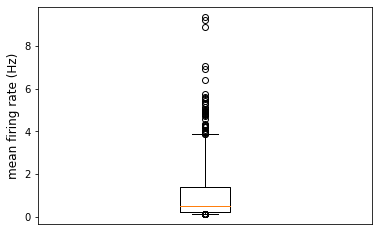

In [8]:
plt.boxplot(mfr_lst, whis=[5, 95])
plt.xticks([])
plt.ylabel('mean firing rate (Hz)', fontsize=12);

Format data to run cross-correlation procedure.

In [9]:
idx_spk_tr, len_spk_tr = scc.format_spike_train(spk_trains)

Compute spike cross-correlation.

In [10]:
n_jobs = 4
cc_lst, idx_sd, tcc = scc.run_cross_par(idx_spk_tr, len_spk_tr, n_jobs=n_jobs)

cross-corr computed in 100.175 seconds


Select the highest correlations

In [95]:
cc_max = np.zeros(len(cc_lst))
for k, cc in enumerate(cc_lst):
    cc_max[k] = np.max(cc)
idx_above = np.where(cc_max > 0.075)[0]

In [114]:
idx_choose = np.random.choice(idx_above)
print(idx_choose)
# 139738, 84551, 138519, 217903

210758


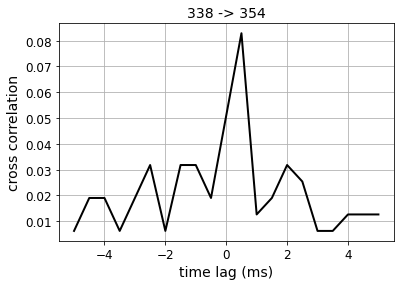

In [115]:
plt.plot(tcc, cc_lst[idx_choose], c='k', lw=2)
src, dst = idx_sd[idx_choose]
plt.title('%d -> %d' % (src, dst), fontsize=14)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time lag (ms)', fontsize=14)
plt.ylabel('cross correlation', fontsize=14);

In [116]:
idx_max = np.argmax(cc_lst[idx_choose])
t_peak = tcc[idx_max]

Compute cross-ISI

In [117]:
src, dst = idx_sd[idx_choose]

In [118]:
len(spk_trains[src])

201

In [119]:
tw = scc.params['tw']
spk_src = spk_trains[src]
spk_dst = spk_trains[dst]
cross_isi = []
for t_src in spk_src:   
    idx = np.where((spk_dst > (t_src - tw)) & (spk_dst < (t_src + tw)))[0]
    c_isi = spk_dst[idx] - t_src
    cross_isi.extend(c_isi)

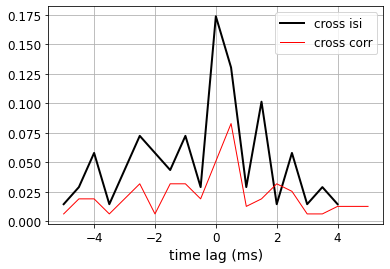

In [120]:
bins = np.arange(-tw, tw, scc.params['dt'])
h = np.histogram(cross_isi, bins=bins)
freq = h[0] / np.sum(h[0])
plt.plot(h[1][:-1], freq, 'k-', lw=2, label='cross isi')
plt.plot(tcc, cc_lst[idx_choose], c='r', lw=1, label='cross corr')
plt.legend(loc=0, fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time lag (ms)', fontsize=14);

Find rows, columns of the two channels !

In [121]:
def get_row_col(id_ch):
    """Return row and column of channel id_ch."""
    row = id_ch // 64
    col = id_ch % 64    
    return row, col

def chan_dist(rc_src, rc_dst):
    """Compute distance between two channels/electrodes."""
    pitch = 80 # um
    d2 = (rc_src[0] - rc_dst[0])**2 + (rc_src[1] - rc_dst[1])**2
    d = np.sqrt(d2) * pitch
    return d

In [122]:
rc_src = get_row_col(id_ch[src])
rc_dst = get_row_col(id_ch[dst])
dist = chan_dist(rc_src, rc_dst)
print(rc_src, rc_dst, dist)
if t_peak:
    vel = dist / t_peak  # um / ms = mm/s
    print('Velocity is %g (mm/s)' %vel.round(1))

(20.0, 21.0) (21.0, 22.0) 113.13708498984761
Velocity is 226.3 (mm/s)


In [123]:
 # report the strongest 10 functional links